In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pygments.lexer import combined
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [99]:
#Load the Titanic dataset from seaborn
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

# Merge the test data with the truth data
test = test.merge(gender_submission, on='PassengerId')

In [100]:
#Summary of the Statistical Data
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


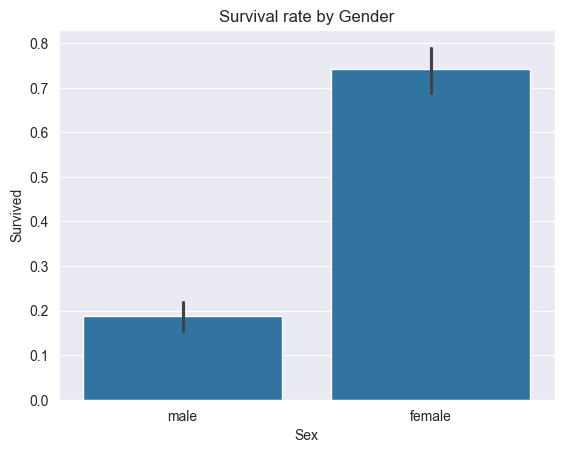

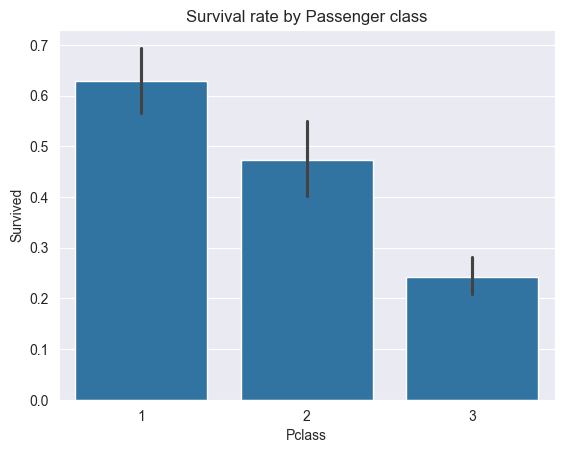

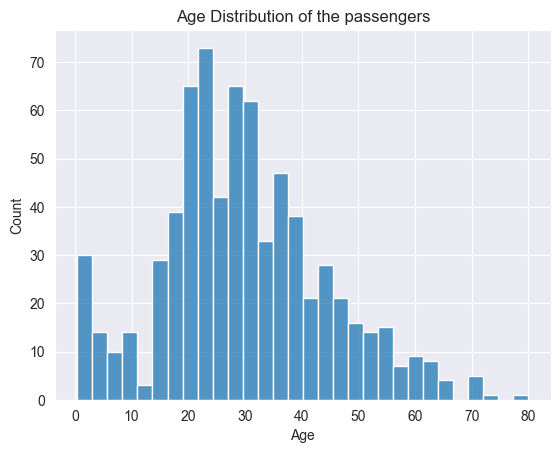

In [101]:
#visualize the data
#what is the survival rate of the passengers by gender?
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival rate by Gender')
plt.show()

#what is the Survival rate of the passengers by class?
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival rate by Passenger class')
plt.show()

#What is the distribution of the age of the passengers?
sns.histplot(train['Age'].dropna(), kde=False, bins=30)
plt.title('Age Distribution of the passengers')
plt.show()


In [102]:
# Data Cleaning and Preprocessing
# Check for missing values
train.isnull().sum()
test.isnull().sum()

# Filling the missing Age with median
train['Age'].fillna(train['Age'].median())
test['Age'].fillna(test['Age'].median())

# Filling the missing Embarked with mode
train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'].fillna(test['Embarked'].mode()[0])

# Remove the Cabin column because it has too many missing values
if 'Cabin' in train.columns:
    train = train.drop('Cabin', axis=1)
if 'Cabin' in test.columns:
    test = test.drop('Cabin', axis=1)

#Checking the dataset for missing values
print(train.isnull().sum())
print(test.isnull().sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
Survived        0
dtype: int64


In [103]:
# Extract titles from names (e.g., Mr, Miss)
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Family size
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

In [104]:
# Combine the train and test data for consistent label encoding
combined = pd.concat([train, test], axis=0).reset_index(drop=True)

# Encoding the categorical variables (Sex, Embarked, Title)
label_encoder = {}
for col in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoder[col] = le

# Split the combined data back into train and test
train = combined.iloc[:len(train)].reset_index(drop=True)
test = combined.iloc[len(train):].reset_index(drop=True)

print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    1  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1      0   
2                             Heikkinen, Miss. Laina    0  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1      0   
4                           Allen, Mr. William Henry    1  35.0      0      0   

             Ticket     Fare  Embarked  Title  FamilySize  
0         A/5 21171   7.2500         2     13           2  
1          PC 17599  71.2833         0     14           2  
2  STON/O2. 3101282   7.9250         2     10           1  
3            113803  53.1000         2     14           

In [105]:
# Model Training
# Split the train data into features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize']
X = train[features]
y = train['Survived']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [106]:
#Prediction of the Validation set
y_pred = model.predict(X_val)
print(f' The Validation Accuracy: {accuracy_score(y_val, y_pred):.2f}')

#predication of the test set compared to the gender_submission
X_test = test[features]
test_pred =model.predict(X_test)
print(f'Test Accuracy: {accuracy_score(test["Survived"], test_pred):.2f}')


 The Validation Accuracy: 0.82
Test Accuracy: 0.84


In [107]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

      Feature  Importance
5        Fare    0.235508
1         Sex    0.227399
2         Age    0.223628
7       Title    0.095595
0      Pclass    0.080101
8  FamilySize    0.052507
3       SibSp    0.032856
6    Embarked    0.030487
4       Parch    0.021920


In [108]:
output = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred
})
output.to_csv('titanic_predictions.csv', index=False)